In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import IPython.display as ipd
from scipy.io.wavfile import read
device = 'cpu'

In [11]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the spectrum of the windowed input signal
  spectrum = fft(sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  plt.plot(magnitude_spectrum)
  plt.ylabel('amplitude (dB)')
  plt.show()

def signal2pytorch(x):
    #Function to convert a signal vector x into a 3-d Tensor that conv1d of Pytorch expects
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals)
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [12]:
# define model graph

class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        # Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank, deconvolution
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        # pass the input signal through the convolutional layer
        x = self.conv1(x)
        # use the tanh activation function
        y = torch.tanh(x)
        return y

    def decoder(self, y):
        # Synthesis
        xrek= self.synconv1(y)
        return xrek

    def forward(self, x):
        y=self.encoder(x)
        xrek=self.decoder(y)
        return xrek

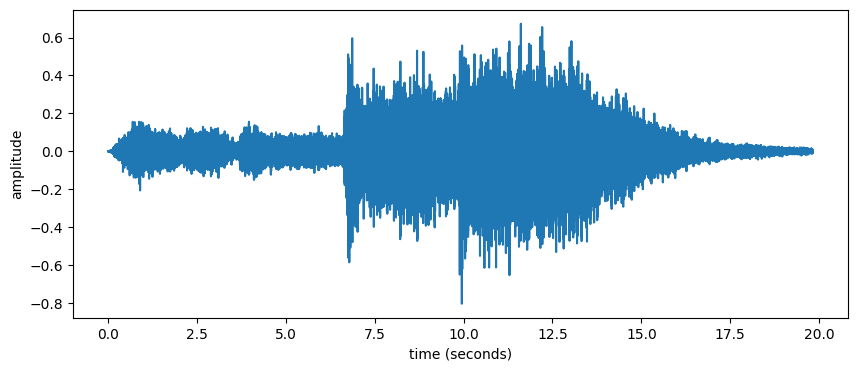

In [13]:
# read training data
batch=1
audio1, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-1.wav")
X_train = signal2pytorch(audio1).to(device)
display_sound(audio1, samplerate)

In [14]:
# Generate Model
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
# loss function used is Mean Square Error
loss_fn = nn.MSELoss()

Ypred = model(X_train)

# length of the signal at the output of the network.
outputlen = len(Ypred[0,0,:])
print("outputlen=", outputlen)

# the target signal with same length as model output
Y=X_train[:,:,:outputlen]

print("Input X.shape =", X_train.shape)
print("Target Y.shape =", Y.shape)
print("Target Y =", Y)
print("Y.type() =", Y.type())

Total number of parameters: 131105
outputlen= 873474
Input X.shape = torch.Size([1, 1, 874006])
Target Y.shape = torch.Size([1, 1, 873474])
Target Y = tensor([[[-0.0003, -0.0003, -0.0003,  ..., -0.0068, -0.0069, -0.0069]]])
Y.type() = torch.FloatTensor


In [15]:
# train model
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Ypred = model(X_train)
print("Ypred=", Ypred)

# train the model over a number of epochs
nepocs = 2000
for epoch in range(nepocs):
  Ypred=model(X_train)
  loss=loss_fn(Ypred, Y)
  if epoch%10==0:
    print(epoch, loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Ypred= tensor([[[-0.0185, -0.0180, -0.0193,  ..., -0.0179, -0.0189, -0.0183]]],
       grad_fn=<ConvolutionBackward0>)
0 0.010153845883905888
10 0.009824373759329319
20 0.009241455234587193
30 0.008375992998480797
40 0.007404601667076349
50 0.006516242865473032
60 0.005801565013825893
70 0.005274503957480192
80 0.004897145088762045
90 0.004623803310096264
100 0.004423570819199085
110 0.00427547050639987
120 0.004161537624895573
130 0.0040665301494300365
140 0.0039804610423743725
150 0.0038975419010967016
160 0.0038144132122397423
170 0.003729357151314616
180 0.0036417709197849035
190 0.0035517392680048943
200 0.0034597052726894617
210 0.0033662384375929832
220 0.0032719136215746403
230 0.003177306614816189
240 0.003083038842305541
250 0.0029898055363446474
260 0.002898342674598098
270 0.0028093531727790833
280 0.002723429352045059
290 0.002641001483425498
300 0.002562324982136488
310 0.002487495308741927
320 0.002416477771475911
330 0.002349144546315074
340 0.0022853086702525616
350 0.

ww= OrderedDict({'conv1.weight': tensor([[[-0.0084,  0.0311, -0.0060,  ..., -0.0098, -0.0097, -0.0333]],

        [[-0.0436, -0.0465, -0.0489,  ..., -0.0123, -0.0100, -0.0104]],

        [[-0.0561, -0.0533, -0.0444,  ...,  0.0491,  0.0507,  0.0404]],

        ...,

        [[ 0.0081,  0.0238,  0.0117,  ..., -0.0046,  0.0033, -0.0191]],

        [[-0.0658, -0.0368, -0.0444,  ..., -0.0082, -0.0061, -0.0244]],

        [[-0.0344, -0.0144, -0.0141,  ...,  0.0106, -0.0063, -0.0126]]]), 'conv1.bias': tensor([-6.7487e-05,  7.6704e-04,  1.1142e-03,  3.6236e-05, -1.1360e-03,
         4.8846e-05,  9.8020e-04,  2.3206e-03, -2.0598e-04, -1.0073e-04,
         9.7068e-04, -1.0033e-03, -6.4956e-04, -6.1698e-04,  1.1088e-03,
         2.4056e-04,  5.4733e-05, -1.9332e-03,  2.7177e-04,  8.2938e-04,
         9.4185e-04, -1.4676e-04, -5.1028e-04,  5.9101e-04,  6.8833e-04,
         3.9924e-04,  1.0215e-03, -1.1725e-04, -7.3905e-04, -3.3448e-05,
         1.2065e-03,  1.1908e-03]), 'synconv1.weight': tensor(

/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_34146/1265710516.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_34146/1265710516.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_34146/1265710516.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  display_spectrum(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])), 44100)


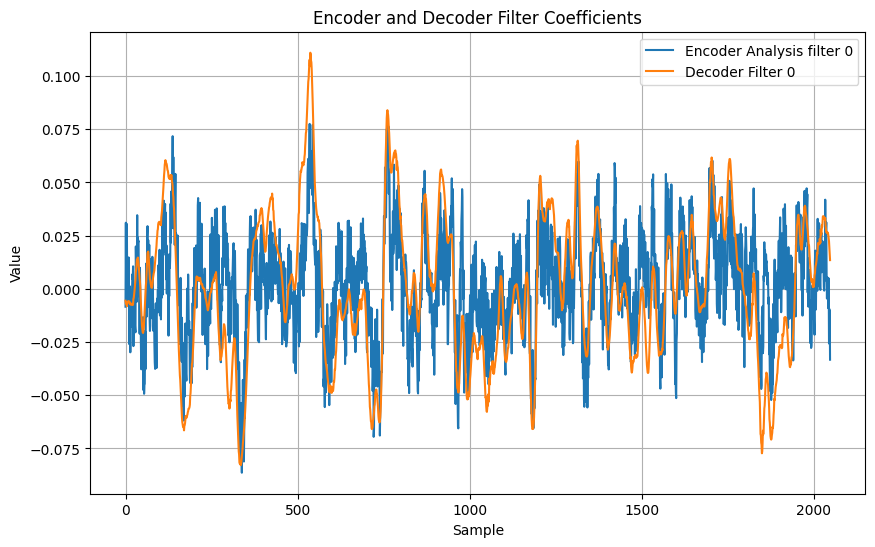

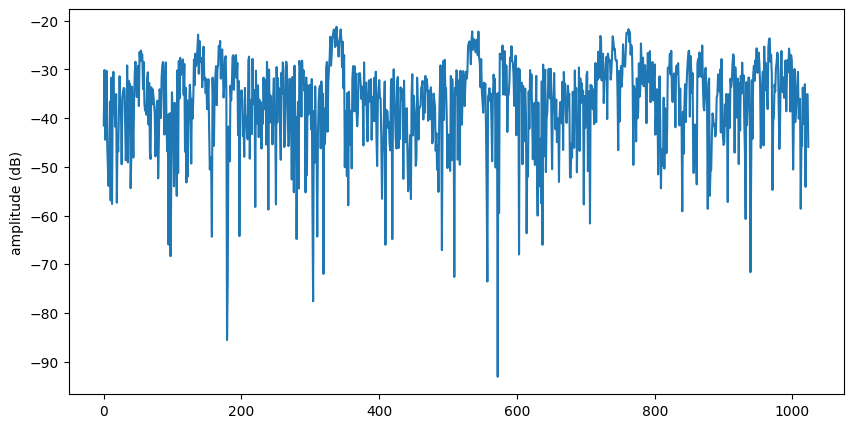

predictions.shape= (1, 1, 873474)


/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_34146/1265710516.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predictions = np.array(predictions)
/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_34146/1265710516.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Y=np.array(Y) #target


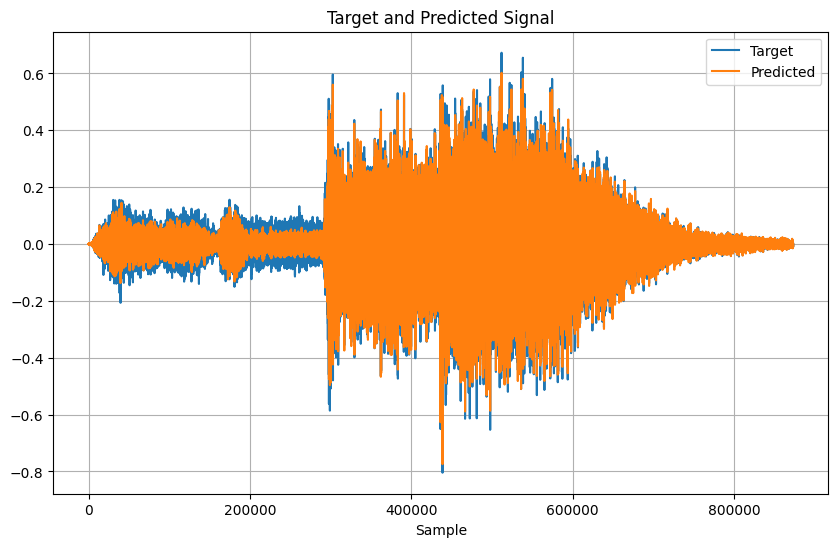

In [16]:
# make predictions using the training set

#read obtained weights
ww = model.state_dict()
print("ww=", ww)

#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Encoder and Decoder Filter Coefficients')
plt.grid()

display_spectrum(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])), 44100)


# Make Predictions based on the obtained weights, on training set
predictions = model(X_train).cpu()
predictions = predictions.detach()
predictions = np.array(predictions)
Y=np.array(Y) #target
print("predictions.shape=", predictions.shape)
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,6))
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Target','Predicted'))
plt.title('Target and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
#remove unnecessary dimension for playback
xrek=predictions[:,0,:]

In [17]:
# play input and predicted sounds
display(ipd.Audio(audio1, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))

/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_34146/1481306101.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predictions = np.array(predictions)
/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_34146/1481306101.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.plot(np.array(X_test[0,0,:]))


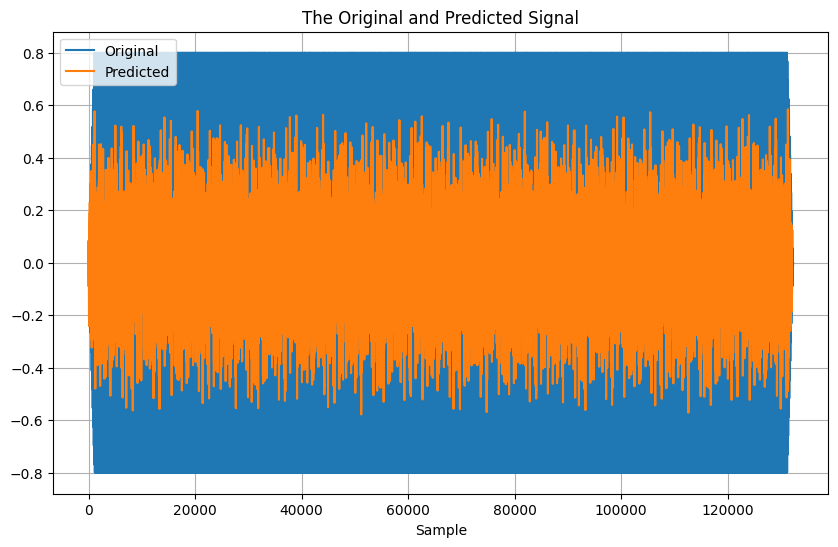

In [19]:
#Test on data different from the training one

# audio2, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-2.wav")
audio2, samplerate = read_sound("../sounds/sinewave.wav")
X_test=signal2pytorch(audio2).to(device) #Convert to pytorch format, batch is first dimension

# Make Predictions based on the obtained weights, on verification set
predictions = model(X_test).cpu()
predictions = predictions.detach()
predictions = np.array(predictions)
plt.figure(figsize=(10,6))
plt.plot(np.array(X_test[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]

In [20]:
#play input and predicted sound
display(ipd.Audio(audio2, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))